In [1]:
import os
workspace_path = '../..'
os.chdir(workspace_path)
print("Current workspace:", os.getcwd())

import pandas as pd
from tqdm import tqdm
import random
import numpy as np

random.seed(0)
np.random.seed(0)

Current workspace: /users/lingze/neurbench


In [2]:
path = "/users/lingze/neurbench/data/name.csv"
keys = []
with open(path, 'r') as f:
    for idx, line in tqdm(enumerate(f.readlines())):
        if idx == 0:
            # skip column
            continue
        # extract the first element as key
        key = line.split(',')[0]
        keys.append(int(key))

4167492it [00:02, 1784561.34it/s]


In [3]:
len(keys) == len(set(keys))

True

In [4]:
max_value = max(keys)
min_value = min(keys)
n = len(keys)
print(f"max: {max_value}, min: {min_value}, n: {n}")

max: 4167491, min: 1, n: 4167491


In [5]:
# write keys to a file
import struct
import os
import numpy as np
keys.sort()

key_file_name = "imdb_4M_uint64"
filepath = os.path.join("/users/lingze/TLI/data", key_file_name)
keys = np.array(keys, dtype = np.uint64)

In [6]:
with open(filepath, 'wb') as f:
    # first write the number of keys
    n = len(keys)
    f.write(struct.pack('Q', n))
    for key in keys:
        f.write(key.tobytes())


In [7]:
data = keys

In [8]:
# then generate the drift bulk_loading key and insert key

In [9]:
import numpy as np
from neuralbench.index.util import load_key_set, KeyType, save_file
from neuralbench.index.bench import KeySetBinEncoder, sample_bulkloading_keyset
from neuralbench.drift import find_q
import matplotlib.pyplot as plt

In [10]:
# since the dataset is totally uniform distributed.
# no need to detect abnormal keys, directly to simulate distribution

Total number of bins: 255


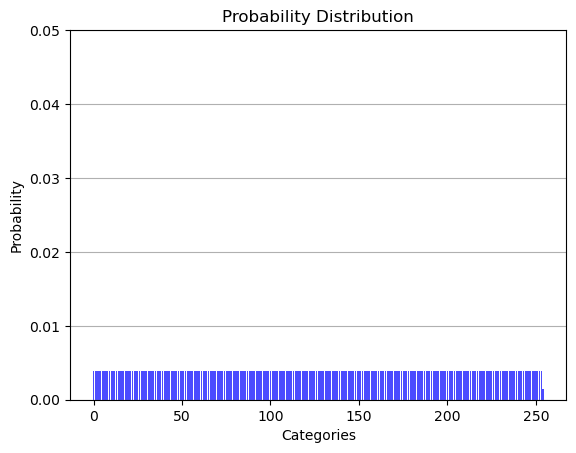

In [11]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 14
bin_idxs, prob, bin_idx_to_keys = KeySetBinEncoder.bin_keyset_to_distribution(
    keys,
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(prob, bin_idxs.tolist())

In [12]:
from collections import defaultdict

min_bin_num = int(np.min(bin_idxs))
max_bin_num = int(np.max(bin_idxs))
prob_dict = defaultdict(float)

for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = prob[i]

x = [ i for i in range(min_bin_num, max_bin_num+1)]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

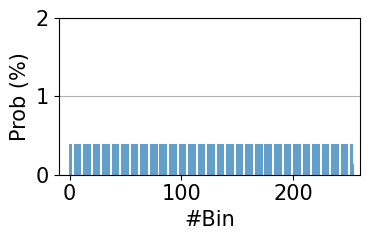

In [13]:

labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
y_ = [ i * 100 for i in y]
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
ax.set_xlim(-10, 260)
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/imdb_4M_uint64_distribution.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

### Drift 0

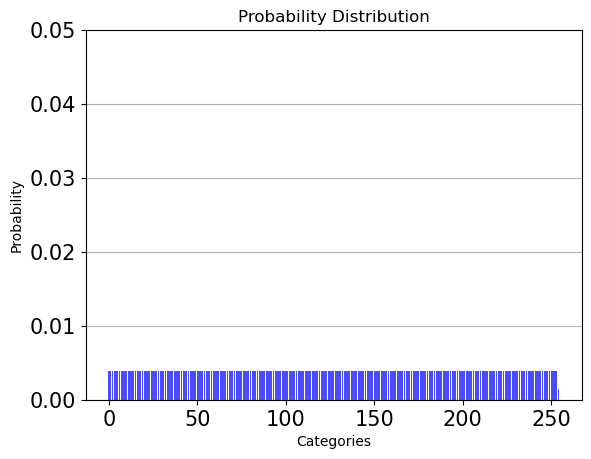

In [14]:
# Drift setting alpha = 0, unform drift
init_prob = find_q(prob, 0, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [15]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding bins: 0 / 255
2083703
Bulkloading key set size: 0.4999898020175688


In [16]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 2083788
Insert ratio: 0.5000101979824312


In [17]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = init_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

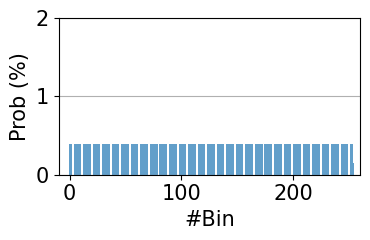

In [18]:
# draw the estimated distribution and store the figure
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
y_ = [ i * 100 for i in y]
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
ax.set_xlim(-10, 260)
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/imdb_4M_uint64_distribution_d0.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [19]:
workload_dir_path = "/users/lingze/neurbench/data/workload/imdb_4M_uint64_drift_00"
os.makedirs(workload_dir_path, exist_ok=True)
data_type = KeyType.UINT64

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

### Drift 0.1

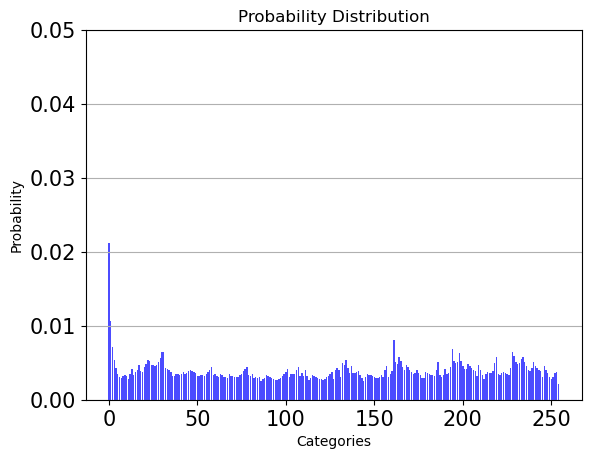

In [20]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.1, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [21]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 0, sample_n: 44235, bound_n: 16383
Exceeding the number of keys in bin 1, sample_n: 22117, bound_n: 16384
Exceeding the number of keys in bin 161, sample_n: 16716, bound_n: 16384
Exceeding bins: 3 / 255
2049701
Bulkloading key set size: 0.4918309361675886


In [22]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 2117790
Insert ratio: 0.5081690638324114


In [23]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = init_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

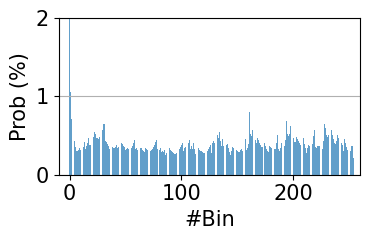

In [24]:
# draw the estimated distribution and store the figure
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
y_ = [ i * 100 for i in y]
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
ax.set_xlim(-10, 260)
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/imdb_4M_uint64_distribution_01.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [25]:
workload_dir_path = "/users/lingze/neurbench/data/workload/imdb_4M_uint64_drift_01"
os.makedirs(workload_dir_path, exist_ok=True)
data_type = KeyType.UINT64

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

### Drift 0.3

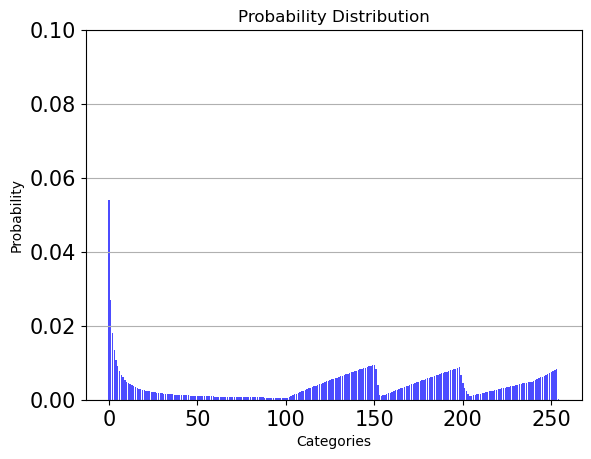

In [26]:
# Drift setting alpha = 0.3, unform drift
init_prob = find_q(prob, 0.3, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [27]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 0, sample_n: 112583, bound_n: 16383
Exceeding the number of keys in bin 1, sample_n: 56323, bound_n: 16384
Exceeding the number of keys in bin 2, sample_n: 37566, bound_n: 16384
Exceeding the number of keys in bin 3, sample_n: 28185, bound_n: 16384
Exceeding the number of keys in bin 4, sample_n: 22555, bound_n: 16384
Exceeding the number of keys in bin 5, sample_n: 18799, bound_n: 16384
Exceeding the number of keys in bin 140, sample_n: 16414, bound_n: 16384
Exceeding the number of keys in bin 141, sample_n: 16756, bound_n: 16384
Exceeding the number of keys in bin 142, sample_n: 17095, bound_n: 16384
Exceeding the number of keys in bin 143, sample_n: 17433, bound_n: 16384
Exceeding the number of keys in bin 144, sample_n: 17769, bound_n: 16384
Exceeding the number of keys in bin 145, sample_n: 18103, bound_n: 16384
Exceeding the number of keys in bin 146, sample_n: 18435, bound_n: 16384
Exceeding the number of keys in bin 147, sample_n: 18765, boun

In [28]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 2288458
Insert ratio: 0.5491212818455997


In [29]:
# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = init_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

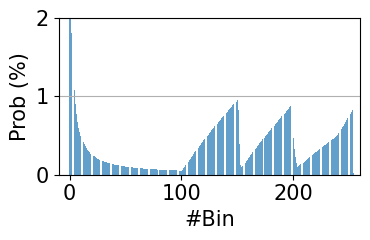

In [30]:
# draw the estimated distribution and store the figure
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
y_ = [ i * 100 for i in y]
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
ax.set_xlim(-10, 260)
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/imdb_4M_uint64_distribution_03.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [31]:
workload_dir_path = "/users/lingze/neurbench/data/workload/imdb_4M_uint64_drift_03"
os.makedirs(workload_dir_path, exist_ok=True)
data_type = KeyType.UINT64

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

### Drift 0.5

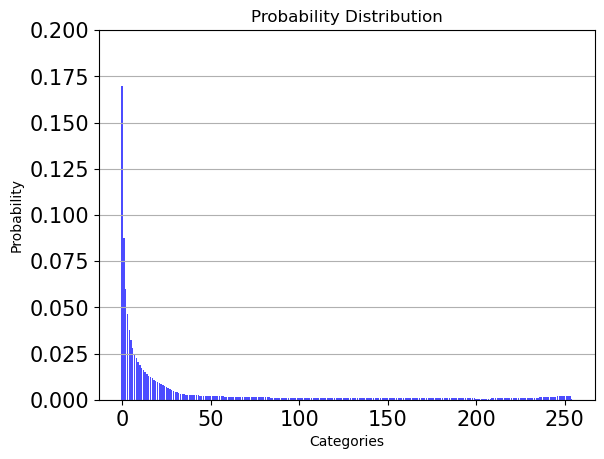

In [32]:
# Drift setting alpha = 0.5, unform drift
init_prob = find_q(prob, 0.5, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [33]:
bulkloading_n = int(0.5 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 0, sample_n: 353253, bound_n: 16383
Exceeding the number of keys in bin 1, sample_n: 182454, bound_n: 16384
Exceeding the number of keys in bin 2, sample_n: 125175, bound_n: 16384
Exceeding the number of keys in bin 3, sample_n: 96296, bound_n: 16384
Exceeding the number of keys in bin 4, sample_n: 78788, bound_n: 16384
Exceeding the number of keys in bin 5, sample_n: 66974, bound_n: 16384
Exceeding the number of keys in bin 6, sample_n: 58416, bound_n: 16384
Exceeding the number of keys in bin 7, sample_n: 51898, bound_n: 16384
Exceeding the number of keys in bin 8, sample_n: 46740, bound_n: 16384
Exceeding the number of keys in bin 9, sample_n: 42535, bound_n: 16384
Exceeding the number of keys in bin 10, sample_n: 39024, bound_n: 16384
Exceeding the number of keys in bin 11, sample_n: 36031, bound_n: 16384
Exceeding the number of keys in bin 12, sample_n: 33437, bound_n: 16384
Exceeding the number of keys in bin 13, sample_n: 31154, bound_n: 16384

In [34]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 3155890
Insert ratio: 0.7572637829331845


In [35]:
# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = init_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

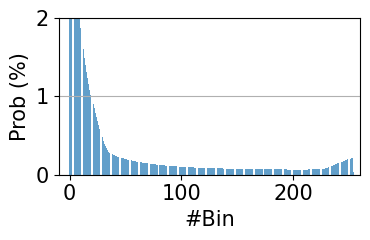

In [36]:
# draw the estimated distribution and store the figure
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
y_ = [ i * 100 for i in y]
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
ax.set_xlim(-10, 260)
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/imdb_4M_uint64_distribution_05.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [37]:
workload_dir_path = "/users/lingze/neurbench/data/workload/imdb_4M_uint64_drift_05"
os.makedirs(workload_dir_path, exist_ok=True)
data_type = KeyType.UINT64

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)

### Drift 0.7

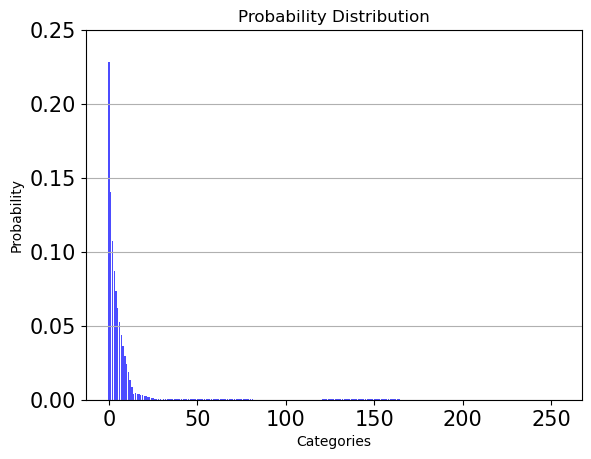

In [38]:
# Drift setting alpha = 0.7, unform drift
init_prob = find_q(prob, 0.7, skewed=True)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [39]:
bulkloading_n = int(1 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 0, sample_n: 952582, bound_n: 16383
Exceeding the number of keys in bin 1, sample_n: 585554, bound_n: 16384
Exceeding the number of keys in bin 2, sample_n: 446096, bound_n: 16384
Exceeding the number of keys in bin 3, sample_n: 363958, bound_n: 16384
Exceeding the number of keys in bin 4, sample_n: 305073, bound_n: 16384
Exceeding the number of keys in bin 5, sample_n: 258073, bound_n: 16384
Exceeding the number of keys in bin 6, sample_n: 218077, bound_n: 16384
Exceeding the number of keys in bin 7, sample_n: 182641, bound_n: 16384
Exceeding the number of keys in bin 8, sample_n: 150405, bound_n: 16384
Exceeding the number of keys in bin 9, sample_n: 123808, bound_n: 16384
Exceeding the number of keys in bin 10, sample_n: 100169, bound_n: 16384
Exceeding the number of keys in bin 11, sample_n: 77726, bound_n: 16384
Exceeding the number of keys in bin 12, sample_n: 56248, bound_n: 16384
Exceeding the number of keys in bin 13, sample_n: 35532, bound_

In [40]:
inserted_keys = np.setdiff1d(data, bulkloading_keys)
print("Insert number of records:", len(inserted_keys))
print("Insert ratio:", len(inserted_keys) / len(data))

Insert number of records: 3629546
Insert ratio: 0.8709187374369854


In [41]:
# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = init_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

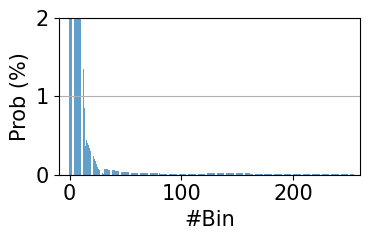

In [42]:
# draw the estimated distribution and store the figure
labels = x
max_value = max(y)
rounded_max_value = np.ceil(max_value * 50) / 50
# rounded 0.05
y_ = [ i * 100 for i in y]
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
ax.set_xlabel('#Bin', fontsize = 15)
ax.set_ylabel('Prob (%)', fontsize = 15)
ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
ax.set_xlim(-10, 260)
ax.grid(axis='y')
fig.tight_layout()
filepath = "/users/lingze/neurbench/data/keys/imdb_4M_uint64_distribution_07.pdf"
fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# Show the plot
fig.show()

In [43]:
workload_dir_path = "/users/lingze/neurbench/data/workload/imdb_4M_uint64_drift_07"
os.makedirs(workload_dir_path, exist_ok=True)
data_type = KeyType.UINT64

inserted_keys = np.array(inserted_keys, dtype=data_type.to_numpy_type())
bulkloading_keys = np.array(bulkloading_keys, dtype=data_type.to_numpy_type())

bulkloading_keyset_file_path = os.path.join(workload_dir_path, "init_keys_uint64")
insert_keyset_file_path = os.path.join(workload_dir_path, "insert_keys_uint64")
save_file(bulkloading_keyset_file_path, bulkloading_keys, data_type)
save_file(insert_keyset_file_path, inserted_keys, data_type)